This notebook contains Hovmoller plots that compare the model output over many different depths to the results from the ORCA Buoy data. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
import json
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
ptrcloc='/ocean/kflanaga/MEOPAR/savedData/201905_ptrc_data'
modver='HC201905' #HC202007 is the other option. 
gridloc='/ocean/kflanaga/MEOPAR/savedData/201905_grid_data'
ORCAloc='/ocean/kflanaga/MEOPAR/savedData/ORCAData'
year=2019
mooring='Twanoh'

In [4]:
# Parameters
year = 2018
modver = "HC201905"
mooring = "Hoodsport"
ptrcloc = "/ocean/kflanaga/MEOPAR/savedData/201905_ptrc_data"
gridloc = "/ocean/kflanaga/MEOPAR/savedData/201905_grid_data"
ORCAloc = "/ocean/kflanaga/MEOPAR/savedData/ORCAData"


In [5]:
orca_dict=io.loadmat(f'{ORCAloc}/{mooring}.mat')

In [6]:
def ORCA_dd_to_dt(date_list):
    UTC=[]
    for yd in date_list:
        if np.isnan(yd) == True:
            UTC.append(float("NaN"))
        else:
            start = dt.datetime(1999,12,31)      
            delta = dt.timedelta(yd)     
            offset = start + delta
            time=offset.replace(microsecond=0)
            UTC.append(time)
    return UTC

In [7]:
obs_tt=[]
for i in range(len(orca_dict['Btime'][1])):
    obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))
#I should also change this obs_tt thing I have here into datetimes    
YD_rounded=[]
for yd in obs_tt:
    if np.isnan(yd) == True:
        YD_rounded.append(float("NaN"))
    else:
        YD_rounded.append(math.floor(yd))
obs_dep=[]
for i in orca_dict['Bdepth']:
    obs_dep.append(np.nanmean(i))

<ipython-input-7-df801a97040c>:3: RuntimeWarning: Mean of empty slice
  obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))
<ipython-input-7-df801a97040c>:13: RuntimeWarning: Mean of empty slice
  obs_dep.append(np.nanmean(i))


In [8]:
grid=xr.open_mfdataset(gridloc+f'/ts_{modver}_{year}_{mooring}.nc')

In [9]:
tt=np.array(grid.time_counter)
mod_depth=np.array(grid.deptht)
mod_votemper=(grid.votemper.isel(y=0,x=0))
mod_vosaline=(grid.vosaline.isel(y=0,x=0))

mod_votemper = (np.array(mod_votemper))
mod_votemper = np.ma.masked_equal(mod_votemper,0).T
mod_vosaline = (np.array(mod_vosaline))
mod_vosaline = np.ma.masked_equal(mod_vosaline,0).T

In [10]:
def Process_ORCA(orca_var,depths,dates,year):
    # Transpose the columns so that a yearday column can be added. 
    df_1=pd.DataFrame(orca_var).transpose()
    df_YD=pd.DataFrame(dates,columns=['yearday'])
    df_1=pd.concat((df_1,df_YD),axis=1)
    #Group by yearday so that you can take the daily mean values. 
    dfg=df_1.groupby(by='yearday')
    df_mean=dfg.mean()
    df_mean=df_mean.reset_index()
    # Convert the yeardays to datetime UTC
    UTC=ORCA_dd_to_dt(df_mean['yearday'])
    df_mean['yearday']=UTC
    # Select the range of dates that you would like. 
    df_year=df_mean[(df_mean.yearday >= dt.datetime(year,1,1))&(df_mean.yearday <= dt.datetime(year,12,31))]
    df_year=df_year.set_index('yearday')
    #Add in any missing date values 
    idx=pd.date_range(df_year.index[0],df_year.index[-1])
    df_full=df_year.reindex(idx,fill_value=-1)
    #Transpose again so that you can add a depth column. 
    df_full=df_full.transpose()
    df_full['depth']=obs_dep
    # Remove any rows that have NA values for depth. 
    df_full=df_full.dropna(how='all',subset=['depth'])
    df_full=df_full.set_index('depth')
    #Mask any NA values and any negative values. 
    df_final=np.ma.masked_invalid(np.array(df_full))
    df_final=np.ma.masked_less(df_final,0)
    return df_final, df_full.index, df_full.columns

## Map of Buoy Location.

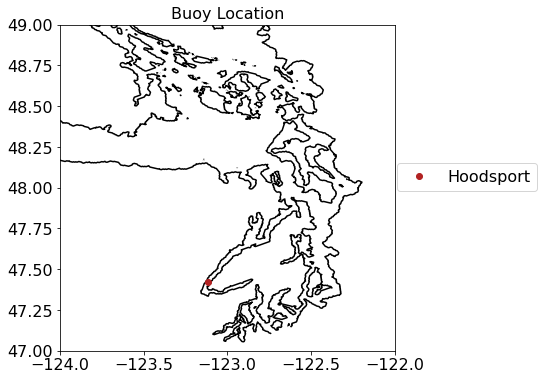

In [11]:
lon,lat=places.PLACES[mooring]['lon lat']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    viz_tools.plot_coastline(ax, bathy, coords = 'map',isobath=.1)
color=('firebrick')
ax.plot(lon, lat,'o',color = 'firebrick', label=mooring)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0.45,0])
ax.set_xlim(-124, -122);
ax.set_title('Buoy Location');

## Temperature

In [12]:
df,dep,tim= Process_ORCA(orca_dict['Btemp'],obs_dep,YD_rounded,year)
date_range=(dt.datetime(year,1,1),dt.datetime(year,12,31))

/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools/Keegan_eval_tools.py:816: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


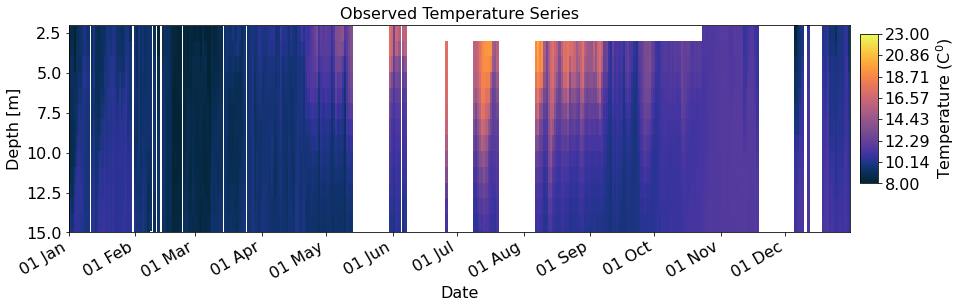

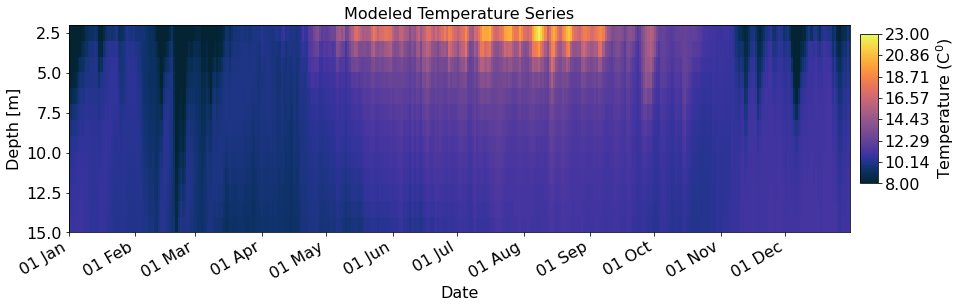

In [13]:
ax=ket.hovmoeller(df,dep,tim,(2,15),date_range,title='Observed Temperature Series',
                  var_title='Temperature (C$^0$)',vmax=23,vmin=8,cmap=cmo.cm.thermal)

ax=ket.hovmoeller(mod_votemper, mod_depth, tt, (2,15),date_range, title='Modeled Temperature Series',
               var_title='Temperature (C$^0$)',vmax=23,vmin=8,cmap=cmo.cm.thermal)

# Salinity

In [14]:
df,dep,tim= Process_ORCA(orca_dict['Bsal'],obs_dep,YD_rounded,year)

/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools/Keegan_eval_tools.py:816: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


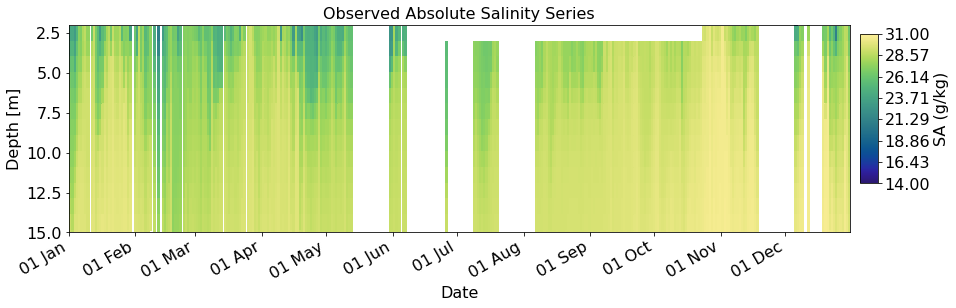

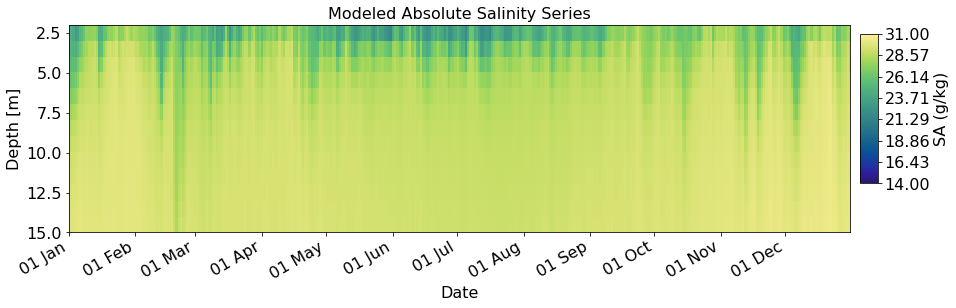

In [15]:
ax=ket.hovmoeller(df,dep,tim,(2,15),date_range,title='Observed Absolute Salinity Series',
               var_title='SA (g/kg)',vmax=31,vmin=14,cmap=cmo.cm.haline)

ax=ket.hovmoeller(mod_vosaline, mod_depth, tt, (2,15),date_range,title='Modeled Absolute Salinity Series',
               var_title='SA (g/kg)',vmax=31,vmin=14,cmap=cmo.cm.haline)

In [16]:
grid.close()

In [17]:
bio=xr.open_mfdataset(ptrcloc+f'/ts_{modver}_{year}_{mooring}.nc')

In [18]:
tt=np.array(bio.time_counter)
mod_depth=np.array(bio.deptht)
mod_flagellatets=(bio.flagellates.isel(y=0,x=0))
mod_ciliates=(bio.ciliates.isel(y=0,x=0))
mod_diatoms=(bio.diatoms.isel(y=0,x=0))

mod_Chl = np.array((mod_flagellatets+mod_ciliates+mod_diatoms)*1.8)
mod_Chl = np.ma.masked_equal(mod_Chl,0).T

In [19]:
df,dep,tim= Process_ORCA(orca_dict['Bfluor'],obs_dep,YD_rounded,year)

/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools/Keegan_eval_tools.py:816: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


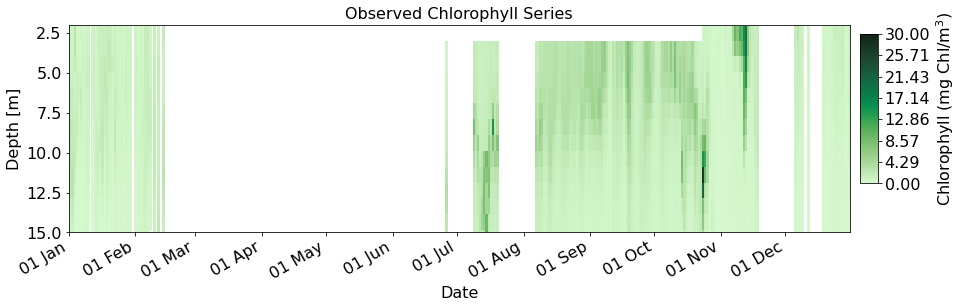

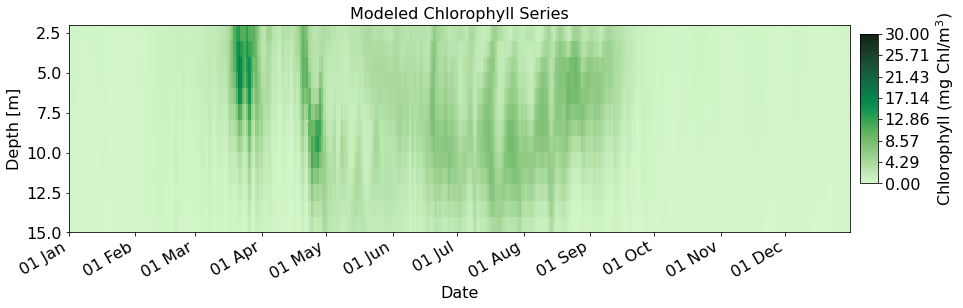

In [20]:
ax=ket.hovmoeller(df,dep,tim,(2,15),date_range,title='Observed Chlorophyll Series',
               var_title='Chlorophyll (mg Chl/m$^3$)',vmin=0,vmax=30,cmap=cmo.cm.algae)

ax=ket.hovmoeller(mod_Chl, mod_depth, tt, (2,15),date_range,title='Modeled Chlorophyll Series',
               var_title='Chlorophyll (mg Chl/m$^3$)',vmin=0,vmax=30,cmap=cmo.cm.algae)

In [21]:
bio.close()